# <font size="7">Modèles génératifs</font>

<font size="3">Statistique en grande dimension et Apprentissage profond.</font>

--- 

Le but de ce TP est de manipuler les deux principaux exemples de modèles génératifs que nous avons vus en cours : les Auto-Encodeurs Variationnels ([VAE](#vae)) et les Réseaux Génératifs Antagonistes ([GAN](#gan)).

In [ ]:
pip install tensorflow == 2.12

In [1]:
import numpy as np
import scipy as sc
import random as rd
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
from keras.datasets import mnist
from tensorflow import keras

import keras.models as km
import keras.layers as kl
import keras.losses as kloss
import keras.regularizers as kr
import keras.backend as K

import tensorflow as tf
tf.__version__

2024-10-08 15:11:13.938109: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-08 15:11:13.963511: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-08 15:11:14.359897: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.12.0'

---

# Auto-Encodeurs Variationnels (VAE) <a id='vae'></a>

Dans un premier temps, nous allons construire un auto-encodeur variationnel simple et appliquer celui-ci (i) à la génération de nombres et (ii) à la détection d'anomalies. Nous allons utiliser le même jeu de données que lors du précédent [TP](https://github.com/j-chevallier/ModIA-HDDL/blob/main/TP-8/TP8_Autoencodeurs.ipynb) sur les auto-encodeurs, à savoir [MNIST](http://yann.lecun.com/exdb/mnist/).

---
## Jeu de données ([MNIST](http://yann.lecun.com/exdb/mnist/))

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('x_train.shape :',x_train.shape)
print('x_test.shape :',x_test.shape)


# Normalisation
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


# Vectorisation
input_dim = np.prod(x_train.shape[1:])
#n_train = x_train.shape[0]
#n_test = x_test.shape[0]
x_train = x_train.reshape((-1, input_dim))
x_test = x_test.reshape((-1, input_dim))


print('\n === After vectorization ===')
print('x_train.shape :',x_train.shape)
print('x_test.shape :',x_test.shape)

x_train.shape : (60000, 28, 28)
x_test.shape : (10000, 28, 28)

 === After vectorization ===
x_train.shape : (60000, 784)
x_test.shape : (10000, 784)


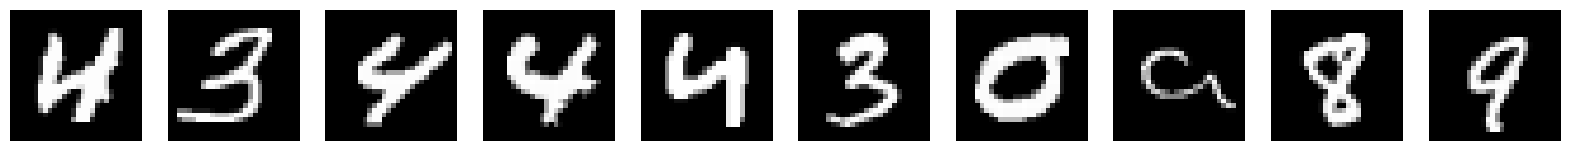

In [4]:
n = 10
idx = [rd.randint(0, x_train.shape[0]) for _ in range(0, n)]

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_train[idx[i]].reshape(28, 28))
    plt.gray()
    ax.grid(False)
    plt.axis('off')
plt.show()

---
## Construction de l'auto-encodeur variationnel

In [5]:
# network parameters
batch_size = 100
epochs = 25

intermediate_dim = 512
latent_dim = 2

### Encodeur

Nous construisons d'abord l'_encodeur_. Il est composé :

1. D'une couche dense de `intermediate_dim = 512` neurones, de fonction d'activation $\texttt{ReLu}$ ;
2. De deux couches dense de `latent_dim = 2` neurones **au-dessus de la même 1ère couche**, de fonction d'activation linéaire. Ces deux couches vont produire les deux variables `z_mean` et `z_log_var` dans l'espace latent. 

##### _**Exercice** : Complétez le code ci-dessous._

In [6]:
# Input layer
inputs = kl.Input(shape=(input_dim,), name='encoder_input')

# Dense layer from input layer
x = kl.Dense(intermediate_dim, activation='relu')(inputs)

# Two dense layer that takes input from the same layer x
z_mean = kl.Dense(latent_dim, name='z_mean')(x)
z_log_var = kl.Dense(latent_dim, name='z_log_var')(x)

2024-10-08 15:11:20.450940: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-10-08 15:11:20.450968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: bichette
2024-10-08 15:11:20.450973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: bichette
2024-10-08 15:11:20.451128: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.171.4
2024-10-08 15:11:20.451146: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.171.4
2024-10-08 15:11:20.451151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.171.4


#### Variable latente stochastique

Nous allons utiliser l'astuce de reparamétrisation pour définir la variable latente aléatoire $z$ conditionnée par rapport l'image d'entrée $x$ selon la loi normale :
$$ z\vert x \sim \mathcal{N}\big(\mu_z(x), \sigma_z(x)\big) \,. $$

<br>
<div><img src="img/vae_3.svg" width="600px" style="display:block; margin-left:auto; margin-right:auto;"/></div>
<br>

L'astuce de reparamétrisation consiste à redéfinir $z$ comme suit :

$$ z\vert x=\mu_z(x)+\sigma_z(x)\cdot\varepsilon \qquad\text{avec}\qquad \varepsilon\sim\mathcal{N}(0,1) \,. $$

Ainsi, la dépendance entre $z$ et $x$ devient déterministe et _différentiable_. De plus, l'aléa de $z$, à $x$ fixé, est uniquement porté par $\varepsilon$.

* Afin de construire la dernière couche de l'encodeur (celle qui rend $z$), on commence par définir une fonction qui, prenant en entrée la sortie de la couche précédente `z_mean`, et `z_log_var`, génère un échantillon aléatoire.

In [7]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim))
    return z_mean + K.exp(z_log_sigma) * epsilon

**Remarque** : L'usage de la fonction exponentielle permet de s'assurer de la positivité de l'écart-type. 
<!-- Autrement dit, on interprète la sortie de la couche `z_log_var` comme étant égale à $\log\big(\sigma^2_z(x)\big)$, et pas seulement $\sigma_z(x)$. -->

* On peut à présent définit une couche $\texttt{keras}$ à partir de cette fonction.

In [8]:
# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`

z = kl.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

* Maintenant que nous avons définis toutes les couches nécessaires à l'élaboration de l'encodeur, on peut l'instancier.

In [9]:
# instantiate encoder model

encoder = km.Model(inputs, z, name='encoder')
encoder.summary()

#tf.keras.utils.plot_model(encoder, show_shapes=True, dpi=64)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          401920      ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 2)            1026        ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 2)            1026        ['dense[0][0]']                  
                                                                                            

### Décodeur 

Le décodeur prend en entrée le vecteur $z$ (_i.e._ l'échantillon de la distribution latente définie par l'encodeur).  Il est ensuite composé de deux couches denses ayant les caractéristiques suivantes : 

* `intermediate_dim = 512` neurones, activation $\texttt{ReLu}$.
* `input_dim = 784` neurones, activation sigmoïde.

##### _**Exercice** : Construisez ce décodeur._

In [10]:
# build decoder model
latent_inputs = kl.Input(shape=(latent_dim,), name='z_sampling')
x = kl.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = kl.Dense(input_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = km.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 512)               1536      
                                                                 
 dense_2 (Dense)             (None, 784)               402192    
                                                                 
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


### Auto-Encodeur

On peut maintenant associer l'encodeur et le décodeur pour définir notre auto-encodeur variationnel.

##### _**Exercice** : Construire le VAE._

In [11]:
# instantiate VAE model
outputs = decoder(encoder(inputs))
vae = km.Model(inputs, outputs, name='vae_mlp')
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 784)]             0         
                                                                 
 encoder (Functional)        (100, 2)                  403972    
                                                                 
 decoder (Functional)        (None, 784)               403728    
                                                                 
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


#### Fonction de perte

Nous implémentons maintenant la fonction de perte "VAE" telle que décrite dans le cours :

$$ \mathcal{L}_{VAE} \,=\, \mathcal{L}(x,\hat{x}) \,+\, KL\big(\, q(z\vert x) \,\vert\vert\, p(z) \,\big) \,, $$

où $\mathcal{L}$ est une fonction de perte adaptée à notre problème entre l'image originale $x$ et l'image reconstruite $\hat{x}$. Comme vu dans le TP précédent, notre choix se porte vers l'entropie croisée binaire. 

$KL$ désigne la divergence de Kullback-Leibler, et $p$ la distribution _a priori_ que l'on met sur la variable latente $z$. Étant donné que

$$ z\vert x\sim\mathcal{N}(\mu_z(x),\sigma_z(x)), $$

nous choisissons comme _a priori_ pour $z$ la loi gaussienne centrée réduite : $z\sim\mathcal{N}(0,1)\,$.






<p style="color:teal">
    <b>Proposition</b> : Soit deux gaussiennes $\, \mathcal{N}_d(\mu_p,\Sigma_p) \,$ et $\, \mathcal{N}_d(\mu_q,\Sigma_q)$. Alors leur divergence K-L est donnée par :
</p>
   
<p style="color:teal">
$$ 
    KL\big(\, \mathcal{N}_d(\mu_q,\Sigma_q) \,\vert\vert\, \mathcal{N}_d(\mu_p,\Sigma_p) \big) \,=\, \frac12 \left[
    \log\frac{\vert\Sigma_p\vert}{\vert\Sigma_q\vert} - d + \textrm{tr}\big(\Sigma_p^{-1}\Sigma_q \big) + \big(\mu_p -
    \mu_q\big)^\top \Sigma_p^{-1}\big(\mu_p - \mu_q\big)\right] \,.
$$
</p>

Dans notre cas, $\, z\sim\mathcal{N}_2(0,I_2) \,$ et $\, z\vert x\sim\mathcal{N}_2(\mu_z(x),\sigma_z(x)) \,$. Ainsi, on a :

$$ 
KL\big(\, q(z\vert x) \,\vert\vert\, p(z) \,\big) \,=\, \frac12 \left[-\log\vert\sigma_z(x)\vert - 2 + \text{tr} \big(\sigma_z(x)\big) +\mu_z(x)^\top \mu_z(x)\right] \,,
$$

ou encore :

$$
KL\big(\, q(z\vert x) \,\vert\vert\, p(z) \,\big) \,=\, \frac12 \, \sum_{j=1}^2 \Big[ \sigma_{z,j}(x) + \mu_{z,j}^2(x) - 2 - \log\sigma_{z,j}(x) \Big] \,.
$$

##### _**Exercice** : On utilisant cette dernière formulation, définir la fonction de perte du VAE._

In [12]:
reconstruction_loss = kloss.binary_crossentropy(inputs,outputs)
reconstruction_loss *= 784

kl_loss = 2 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

### Entraînement et Résultats

Sur un ordinateur classique, sans GPU, l'entraînement prend environ 5 secondes par epoch.

In [13]:
vae.fit(x_train,
        epochs=40,
        batch_size=batch_size,
        validation_data=(x_test, None))

Epoch 1/40
600/600 [==============================] - 6s 9ms/step - loss: 200.0804 - val_loss: 174.6735
Epoch 2/40
600/600 [==============================] - 5s 8ms/step - loss: 169.9504 - val_loss: 166.0722
Epoch 3/40
600/600 [==============================] - 4s 7ms/step - loss: 164.4039 - val_loss: 162.7735
Epoch 4/40
600/600 [==============================] - 5s 8ms/step - loss: 161.9868 - val_loss: 161.1719
Epoch 5/40
600/600 [==============================] - 5s 8ms/step - loss: 160.1631 - val_loss: 159.1336
Epoch 6/40
600/600 [==============================] - 5s 8ms/step - loss: 158.6068 - val_loss: 157.7942
Epoch 7/40
600/600 [==============================] - 5s 8ms/step - loss: 157.1500 - val_loss: 156.3240
Epoch 8/40
600/600 [==============================] - 5s 8ms/step - loss: 155.6585 - val_loss: 155.3137
Epoch 9/40
600/600 [==============================] - 5s 8ms/step - loss: 154.4431 - val_loss: 154.1403
Epoch 10/40
600/600 [==============================] - 5s 9ms/st

On peut maintenant vérifier rapidement la performance du modèle en visualisant des exemples d'images de la base de test et de leur reconstruction.

100/100 [==============================] - 0s 2ms/step


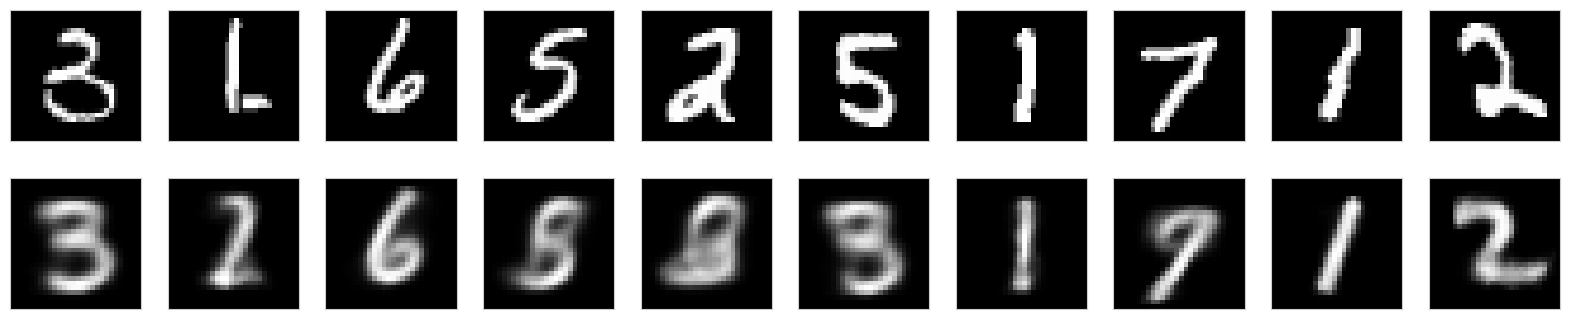

In [14]:
x_test_decoded_vae = vae.predict(x_test, batch_size= batch_size)

n = 10
idx = [rd.randint(0, x_test.shape[0]) for _ in range(0, n)]

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[idx[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(x_test_decoded_vae[idx[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

---
## Visualisation de l'entraînement

Afin de visualiser l'entraînement, nous aimerions afficher l'évolution des chiffres au cours de celui-ci.

La fonction ci-dessous compile les codes définis précédement afin d'instancer un VAE, et sa perte associée.

In [16]:
def make_vae(intermediate_dim=512, latent_dim=2) :
    # Encoder
    inputs = kl.Input(shape=(input_dim,), name='encoder_input')
    x = kl.Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = kl.Dense(latent_dim, name='z_mean')(x)
    z_log_var = kl.Dense(latent_dim, name='z_log_var')(x)
    z = kl.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    encoder = km.Model(inputs, z, name='encoder')

    # Decoder
    latent_inputs = kl.Input(shape=(latent_dim,), name='z_sampling')
    x = kl.Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = kl.Dense(input_dim, activation='sigmoid')(x)
    decoder = km.Model(latent_inputs, outputs, name='decoder')
    
    # VAE
    outputs = decoder(encoder(inputs))
    vae = km.Model(inputs, outputs, name='vae_mlp')
    
    # Loss
    reconstruction_loss = kloss.binary_crossentropy(inputs,outputs)
    reconstruction_loss *= 784

    kl_loss = 2 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5

    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    
    return encoder, decoder, vae

##### _**Exercice** : Sur le même ensemble d'image que précédement, regarder l'évolution des prédictions._

On pourra par exemple afficher les prédictions pour les 10 premières epochs d'entraînement du VAE.

=== Epoch 0/10 ===
100/100 [==============================] - 0s 2ms/step
=== Epoch 1/10 ===
100/100 [==============================] - 0s 3ms/step
=== Epoch 2/10 ===
100/100 [==============================] - 0s 3ms/step
=== Epoch 3/10 ===
100/100 [==============================] - 0s 2ms/step
=== Epoch 4/10 ===
100/100 [==============================] - 0s 3ms/step
=== Epoch 5/10 ===
100/100 [==============================] - 0s 4ms/step
=== Epoch 6/10 ===
100/100 [==============================] - 0s 3ms/step
=== Epoch 7/10 ===
100/100 [==============================] - 0s 4ms/step
=== Epoch 8/10 ===
100/100 [==============================] - 0s 3ms/step
=== Epoch 9/10 ===
100/100 [==============================] - 0s 3ms/step
=== Epoch 10/10 ===
100/100 [==============================] - 1s 5ms/step


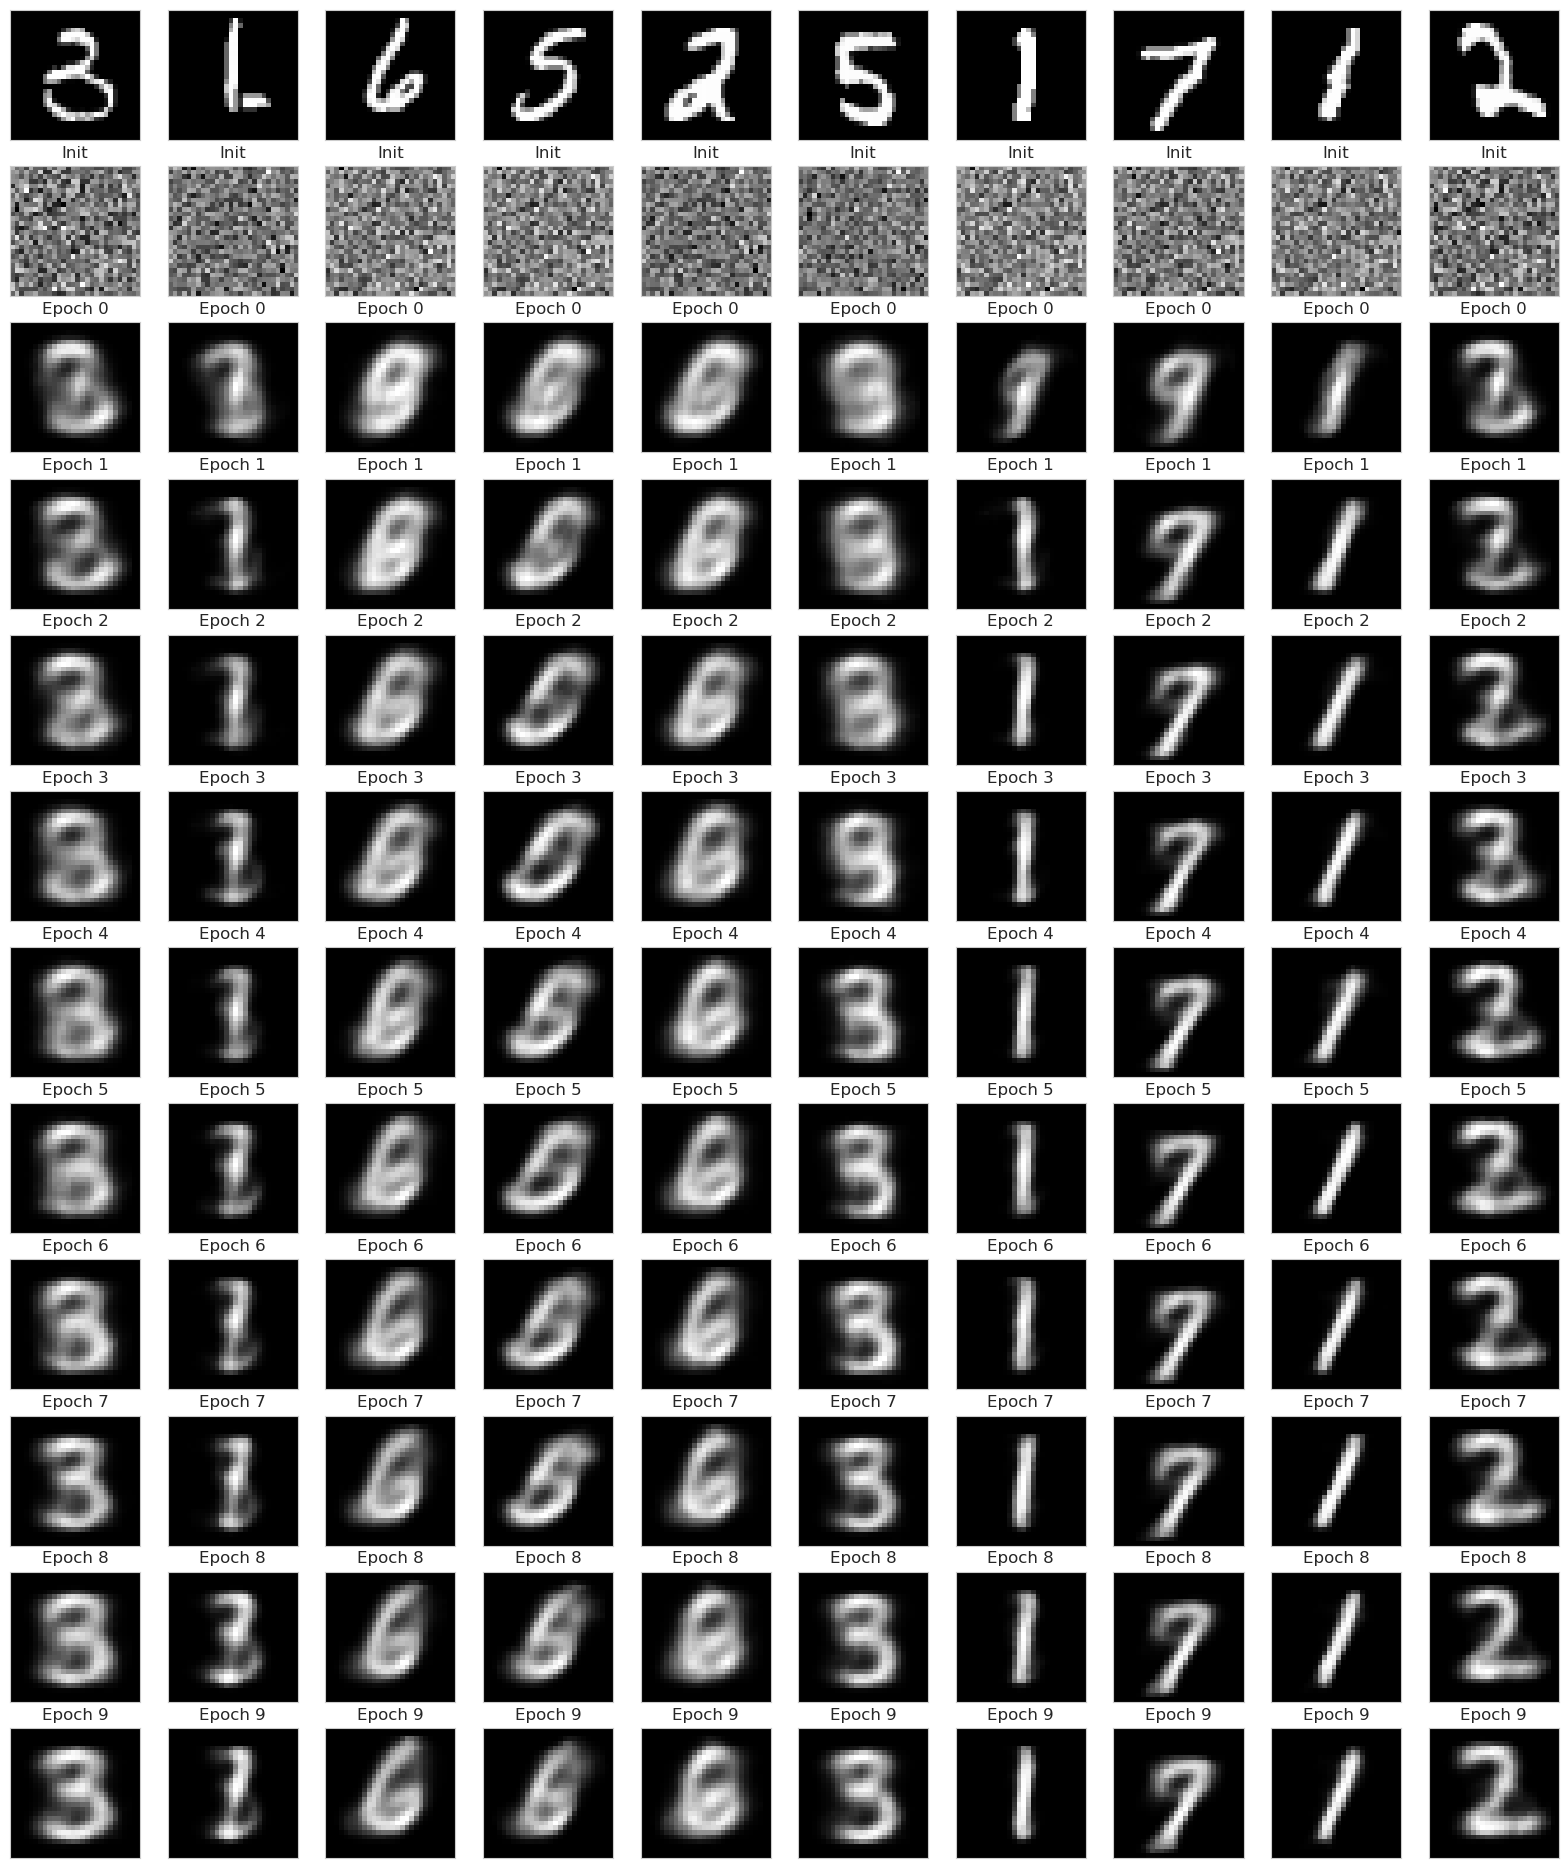

<Figure size 640x480 with 0 Axes>

In [18]:
n = 10
m = 10

# We keep the same data as before
# idx = [rd.randint(0, x_test.shape[0]) for _ in range(0, n)]

encoder_seq, decoder_seq, vae_seq = make_vae()
vae_seq.compile(optimizer='adam')

plt.figure(figsize=(2*n, 2*(m+2)))


# display original
for i in range(n):
    ax = plt.subplot(m+2, n, i+1)
    plt.imshow(x_test[idx[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
print("=== Epoch 0/"+str(m)+" ===")
x_test_decoded_vae_seq = vae_seq.predict(x_test, batch_size=batch_size)

# display initialization
for i in range(n):
    ax = plt.subplot(m+2, n, i+1 + n)
    plt.imshow(x_test_decoded_vae_seq[idx[i]].reshape(28, 28))
    plt.title('Init')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
for j in range(m):
    print("=== Epoch "+str(j+1)+"/"+str(m)+" ===")  
    vae_seq.fit(x_train,
            epochs=1,
            batch_size=batch_size,
            validation_data=(x_test, None),
            verbose=0)
    
    x_test_decoded_vae_seq = vae_seq.predict(x_test, batch_size=batch_size)
    
    # display reconstruction
    for i in range(n):
        ax = plt.subplot(m+2, n, i+1 + (j+2)*n)
        plt.imshow(x_test_decoded_vae_seq[idx[i]].reshape(28, 28))
        plt.title('Epoch '+str(j))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
            
plt.show()
plt.tight_layout()

---
## Classification de la variable latente

Quelle est la distribution des différents chiffres sur l'espace latent ?

##### _**Exercice** : Pour répondre à cette question, représenter le nuage de points des chiffres encodés, selon la valeur de leur label._

100/100 [==============================] - 0s 993us/step


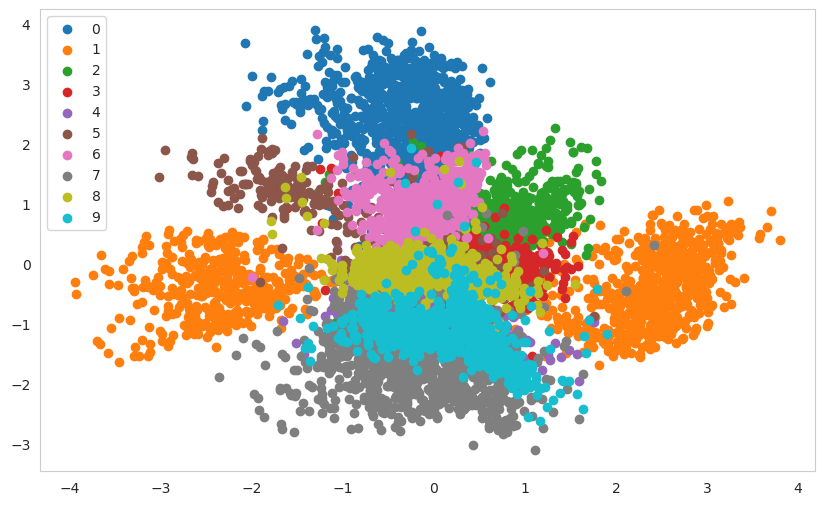

In [20]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(1,1,1)

for i in range(10):
    x_test_encoded_i = x_test_encoded[y_test==i]
    plt.scatter(x_test_encoded_i[:, 0], x_test_encoded_i[:, 1], label=i)
ax.grid(False)
plt.legend()

plt.show()

---
## Génération de nouveaux nombres

On peut utiliser le caractère génératif du VAE pour générer de nouvelles données, en l'occurrence de nouveaux chiffres.

##### _**Exercice** : Générer une nouvelle image._

Pour cela, on pourra générer une réalisations de la variable latente aléatoire $z$ et utiliser le décodeur.

1/1 [==============================] - 0s 22ms/step


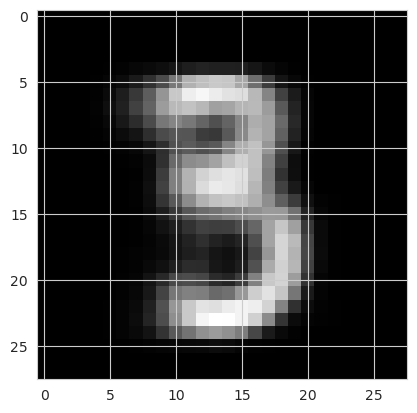

In [22]:
z_latent = np.expand_dims(np.random.normal(0,1,2), axis=0)
x_generate = decoder.predict(z_latent)
plt.imshow(x_generate[0].reshape(28, 28))

On peut également visualiser la variété associée à l'espace latent.

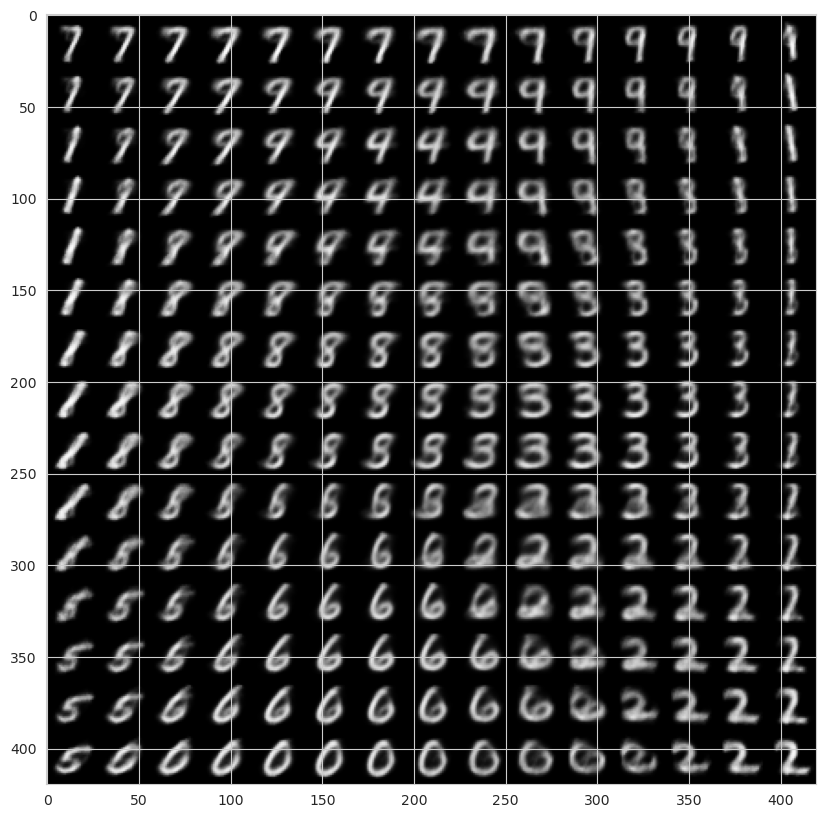

In [23]:
n = 15  # figure with 15x15 panels
digit_size = 28

figure = np.zeros((digit_size * n, digit_size * n))
grid_x = sc.stats.norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = sc.stats.norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
#plt.gray()
plt.show()

---
## Détection d'anomalies

Dans cette (avant-dernière) partie, nous allons voir comment les auto-encodeurs variationnels peuvent être utilisés pour réaliser de la détection d'anomalies.

Pour cela, nous allons considérer que les images de 9 sont des valeurs aberrantes. Nous allons générer quatre jeux de données à partir des jeux de données d'entraînement et de test, à savoir :
* Données d'entraînement et de test sans les 9,
* Données d'entraînement et de test avec seulement les images de 9.


In [24]:
outlier_i = 9


# Dataset without i=9
x_train_ad = x_train[y_train!=outlier_i]
n_train = x_train_ad.shape[0]-x_train_ad.shape[0]%100
x_train_ad = x_train_ad[:n_train]

x_test_ad =  x_test[y_test!=outlier_i]
n_test = x_test_ad.shape[0]-x_test_ad.shape[0]%100
x_test_ad = x_test_ad[:n_test]


# Dataset with only i=9
anomaly_train = x_train[y_train==outlier_i]
n_train = anomaly_train.shape[0]-anomaly_train.shape[0]%100
anomaly_train = anomaly_train[:n_train]

anomaly_test =  x_test[y_test==outlier_i]
n_test = anomaly_test.shape[0]-anomaly_test.shape[0]%100
anomaly_test = anomaly_test[:n_test]


x_train_ad.shape, anomaly_train.shape, x_test_ad.shape, anomaly_test.shape

((54000, 784), (5900, 784), (8900, 784), (1000, 784))

##### _**Exercice** : Construire un VAE pour la détection du chiffre 9_.

Pour cela :
1. Construisez un VAE similaire à celui que nous avons étudié, et entraîner sur le jeu de données ne contenant pas le chiffre 9.
2. Puis, visualisez le résultat de la reconstruction sur le jeu de données composés des chiffres de 0 à 8 d'une part, et sur le jeu de données composés du chiffre 9 uniquement d'autre part. 
3. Que constatez-vous ?

In [ ]:
## A COMPLETER ##

[...]

In [26]:
# %load solutions/vae/vae_anomaly.py
encoder_ad, decoder_ad, vae_ad = make_vae()
vae_ad.compile(optimizer='adam')

vae_ad.fit(x_train_ad, 
           epochs = 40, 
           batch_size = batch_size, 
           validation_data = (x_test_ad, None))

Epoch 1/40
540/540 [==============================] - 5s 9ms/step - loss: 193.5734 - val_loss: 169.0567
Epoch 2/40
540/540 [==============================] - 5s 9ms/step - loss: 165.4107 - val_loss: 163.5119
Epoch 3/40
540/540 [==============================] - 4s 8ms/step - loss: 161.6692 - val_loss: 160.8925
Epoch 4/40
540/540 [==============================] - 5s 9ms/step - loss: 159.3471 - val_loss: 158.7731
Epoch 5/40
540/540 [==============================] - 4s 8ms/step - loss: 157.4380 - val_loss: 157.1932
Epoch 6/40
540/540 [==============================] - 4s 8ms/step - loss: 155.9478 - val_loss: 155.8559
Epoch 7/40
540/540 [==============================] - 5s 9ms/step - loss: 154.7121 - val_loss: 155.0347
Epoch 8/40
540/540 [==============================] - 5s 9ms/step - loss: 153.6566 - val_loss: 154.0458
Epoch 9/40
540/540 [==============================] - 4s 8ms/step - loss: 152.8003 - val_loss: 153.5896
Epoch 10/40
540/540 [==============================] - 4s 8ms/st

### Images décodées par le VAE 

Utilisons à présent notre VAE sur l'ensemble de données de test avec les nombres connus (0 à 8) d'une part, et sur les valeurs aberrantes (9) d'autre part.

#### Données d'entraînement régulières

In [ ]:
## A COMPLETER ##

[...]

89/89 [==============================] - 0s 3ms/step


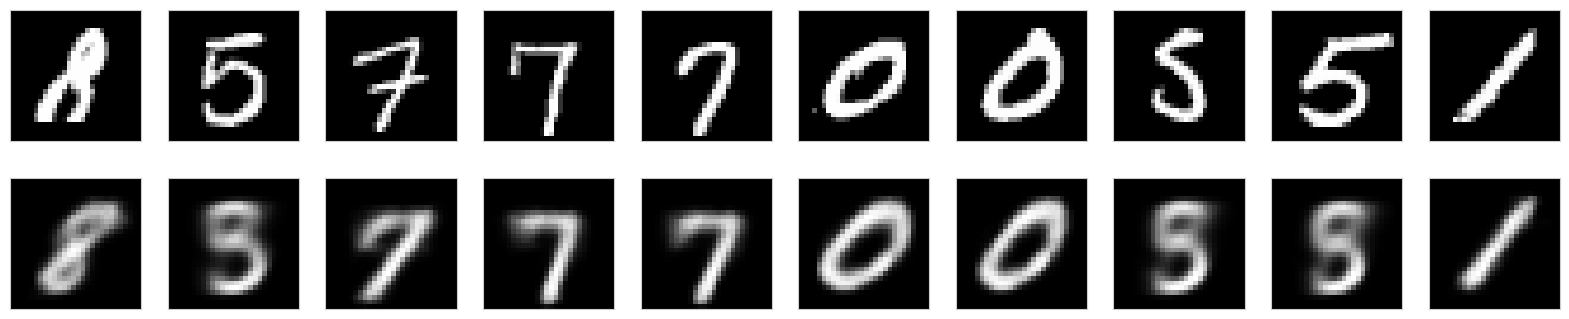

In [28]:
# %load solutions/vae/vae_anomaly_regular.py
x_test_decoded_ad = vae_ad.predict(x_test_ad, batch_size=batch_size)

n = 10
idx = [rd.randint(0, x_test_ad.shape[0]) for _ in range(0, n)]

plt.figure(figsize=(2*n, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_ad[idx[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(x_test_decoded_ad[idx[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

#### Données aberrantes

In [ ]:
## A COMPLETER ##

[...]

10/10 [==============================] - 0s 2ms/step


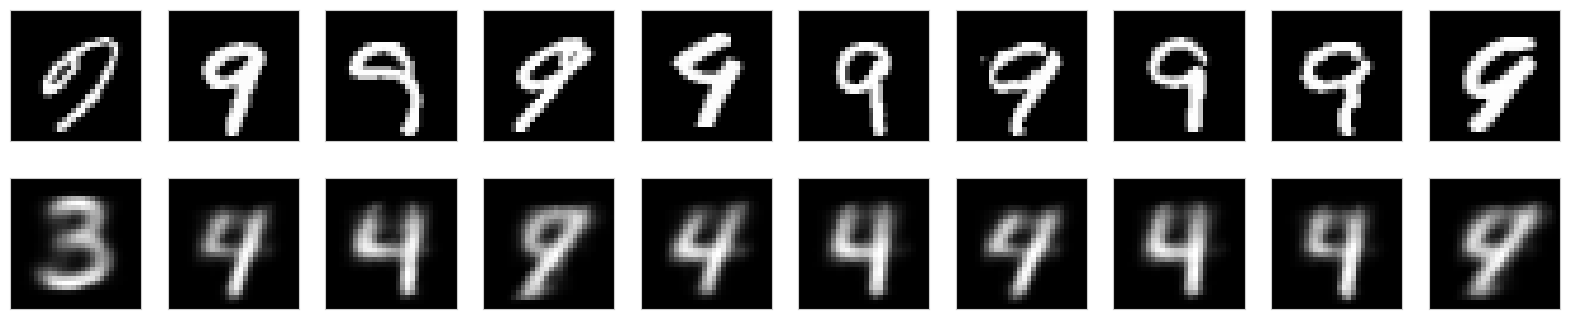

In [30]:
# %load solutions/vae/vae_anomaly_outliers.py
anomaly_decoded = vae_ad.predict(anomaly_test, batch_size=batch_size)

n = 10
idx = [rd.randint(0, anomaly_test.shape[0]) for _ in range(0, n)]

plt.figure(figsize=(2*n, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(anomaly_test[idx[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(anomaly_decoded[idx[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Détection d'anomalies à l'aide de la représentation latente

En réalisant un clustering "Normal-vs-Outliers" dans l'espace latent, on peut espérer détecter les anomalies. 

##### _**Exercice** : Comparer la distribution des encodages des données régulières et aberrantes._

Pour cela, on pourra visualiser le nuage de points correspondant au données normales d'une part, et aux données aberrantes d'autre part, sur me même graphique. Peut-on mettre facilement en place une technique de clustering ?

In [ ]:
## A COMPLETER ##

[...]

10/10 [==============================] - 0s 863us/step


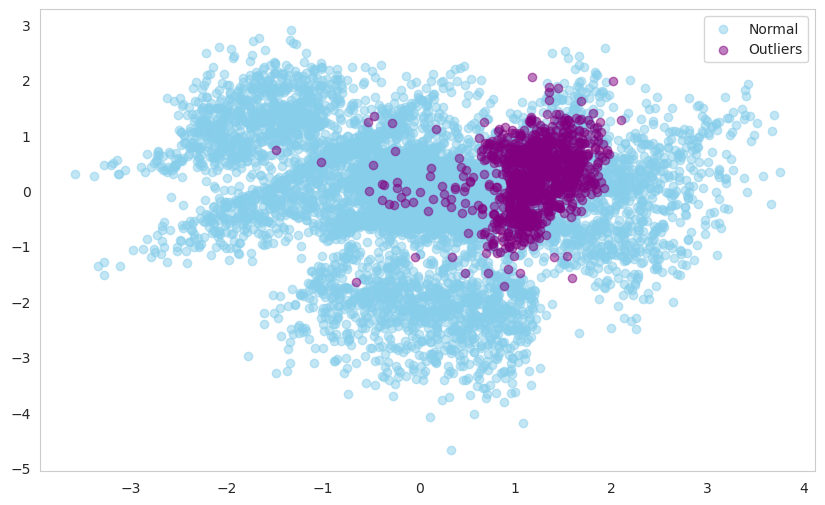

In [32]:
# %load solutions/vae/vae_anomaly_reg_vs_out.py
x_test_encoded_ad = encoder_ad.predict(x_test_ad, batch_size=batch_size)
anomaly_encoded = encoder_ad.predict(anomaly_test, batch_size=batch_size)

fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(1,1,1)
    
plt.scatter(x_test_encoded_ad[:, 0], x_test_encoded_ad[:, 1], color="skyblue", alpha=.5, label="Normal")
plt.scatter(anomaly_encoded[:, 0], anomaly_encoded[:, 1], color="purple", alpha=.5, label="Outliers") 
    
ax.grid(False)
plt.legend()
plt.show()

On peut vouloir regarder une transformation de l'espace latent, par exemple en utilisant l'algorithme TSNE non linéaire, pour voir si la séparation est alors plus franche.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9900 samples in 0.002s...
[t-SNE] Computed neighbors for 9900 samples in 0.077s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9900
[t-SNE] Computed conditional probabilities for sample 2000 / 9900
[t-SNE] Computed conditional probabilities for sample 3000 / 9900
[t-SNE] Computed conditional probabilities for sample 4000 / 9900
[t-SNE] Computed conditional probabilities for sample 5000 / 9900
[t-SNE] Computed conditional probabilities for sample 6000 / 9900
[t-SNE] Computed conditional probabilities for sample 7000 / 9900
[t-SNE] Computed conditional probabilities for sample 8000 / 9900
[t-SNE] Computed conditional probabilities for sample 9000 / 9900
[t-SNE] Computed conditional probabilities for sample 9900 / 9900
[t-SNE] Mean sigma: 0.049244
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.963219
[t-SNE] KL divergence after 500 iterations: 1.025624


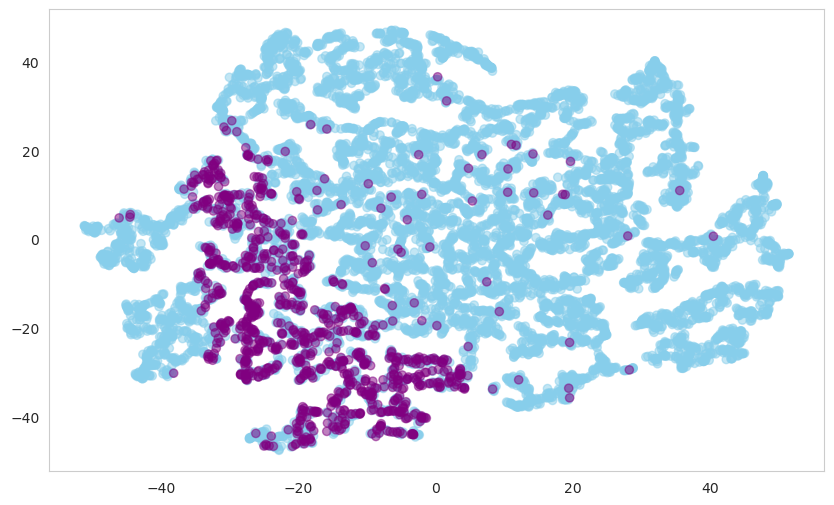

In [33]:
from sklearn.manifold import TSNE

latent_space_tsne = TSNE(2, verbose = True, n_iter = 500)
xa_tsne = latent_space_tsne.fit_transform(np.concatenate([x_test_encoded_ad, anomaly_encoded],0))


fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(1,1,1)

plt.scatter(xa_tsne[:,0], xa_tsne[:,1],
            color=(['skyblue']*x_test_encoded_ad.shape[0])+['purple']*anomaly_encoded.shape[0], alpha = 0.5)

ax.grid(False)
#plt.legend()
plt.show()

### Distribution de l'erreur de reconstruction

Pour évaluer le fonctionnement de la détection des images 9, vérifions la distribution des différentes erreurs $l_2$ entre l'image originale et leur image reconstruite pour trois types d'images :

* Images de nombre connu (0 à 8),
* Images aberrantes (9),
* Images générées de façon complètement aléatoire.

##### _**Exercice** : Construisez un histogramme des erreurs de reconstruction pour chacune des trois situation._

In [ ]:
## A COMPLETER ##

# Regular data
[...]
mse_normal = ...

# Outliers data
[...]
mse_outliers = ...

# Random data
[...]
mse_random = ...

10/10 [==============================] - 0s 1ms/step


/home/sara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


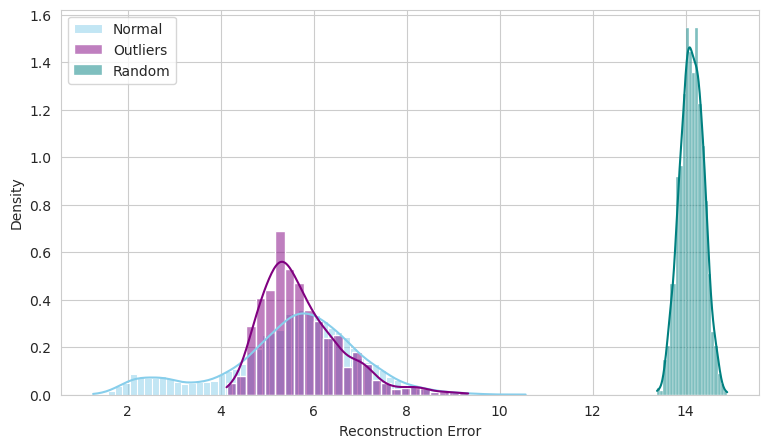

In [35]:
# %load solutions/vae/vae_hist.py
# Regular data
x_test_decoded_ad = vae_ad.predict(x_test_ad, batch_size=batch_size)
mse_normal = np.linalg.norm(x_test_ad-x_test_decoded_ad, axis=1)

# Outliers data
anomaly_decoded = vae_ad.predict(anomaly_test, batch_size=batch_size)
mse_outliers = np.linalg.norm(anomaly_test-anomaly_decoded, axis=1)

# Random data
x_random = np.random.uniform(size=(1000, 784),low=0.0, high=1.0)
x_random_decoded =  vae_ad.predict(x_random, batch_size=batch_size)
mse_random = np.linalg.norm(x_random-x_random_decoded, axis=1)


# Histograms 
fig = plt.figure(figsize=(9,5))
ax = plt.subplot(1,1,1)

sns.histplot(data=mse_normal, stat='density', color="skyblue", ax=ax, label="Normal", kde=True)
sns.histplot(data=mse_outliers, stat='density', color="purple", ax=ax, label="Outliers", kde=True)
sns.histplot(data=mse_random, stat='density', color="teal", ax=ax, label="Random", kde=True)

ax.set_xlabel('Reconstruction Error')
plt.legend()
plt.show()

_**Question** : Que pouvez-vous dire de la reconstruction des erreurs dans les différents cas ? Concluez quant à la performance du VAE pour détecter les anomalies._

On peut également "mesurer" la performance du d'un tel classifieur à l'aide d'une courbe ROC.

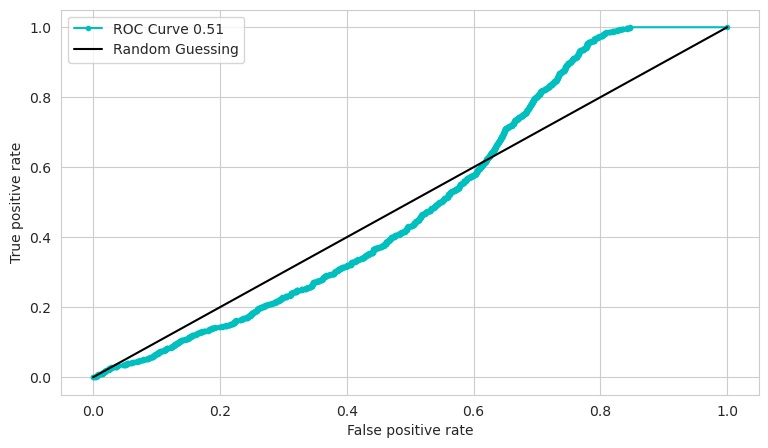

In [36]:
from sklearn.metrics import roc_auc_score, roc_curve

mse_score = np.concatenate([mse_normal,mse_outliers], 0)
true_label = [0]*x_test_ad.shape[0] + [1]*anomaly_test.shape[0]

if roc_auc_score(true_label, mse_score)<0.5 :
    mse_score *= -1
    
fpr, tpr, thresholds = roc_curve(true_label, mse_score)
auc_score = roc_auc_score(true_label, mse_score)

fig, ax = plt.subplots(1, 1, figsize = (9,5))

ax.plot(fpr, tpr, 'c.-', label = 'ROC Curve {:2.2f}'.format(auc_score))
ax.plot(fpr, fpr, 'k-', label = 'Random Guessing')

ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
plt.legend()
plt.show()

Clairement, le résultat n'est pas très concluant ici. On peut essayer d'améliorer l'architecture de notre VAE pour améliorer la performance !

---
## Auto-encodeurs variationnels et convolutifs

**Exercice (Pour aller plus loin)** : Nous avons vu comment construire un VAE et comment l'utiliser pour générer de nouvelles images et détecter des anomalies. Les VAE utilisés jusqu'à présent n'utilisent que des couches denses (MLP), ce qui peut expliquer leur manque d'efficacité pour la détection d'anomalies. 

Utilisez des couches CNN pour construire un VAE convolutif et testez les différentes applications (générer des images et détecter des anomalies).

---

# Réseaux Génératifs Antagonistes (GAN) <a id='gan'></a>

Le but de cette seconde partie est de manipuler des réseaux antagonistes. 

--- 

## Réseau "jouet" en dimension 1

Compte-tenu de la lenteur d'entraînement des GANs, pour arriver à faire tourner un premier réseau dans la durée impartie pa TP, nous commençons par considérer un simple réseau unidimensionnel sur des données jouets.

### Jeu de données

La première étape consiste à créer un jeu de données.

##### _**Exercice** : Construisez un jeu de données unidimensionnel._

Pour cela :
1. Choisissez une fonction numérique $f$, par exemple la fonction $f\colon x\mapsto x^2$,
2. Générer $n=100$ points répartis _aléatoirement_ le long de la courbe représentative de $f$,
3. Contrôlez la bonne dispersion des points à l'aide d'un nuage de points.

In [ ]:
## A COMPLETER ##

[...]

In [ ]:
%load solutions/gan/gan_data.py

### Discriminateur

La prochaine étape consiste à définir le discriminateur. 

Le discriminateur est un classifieur qui prend en entrée des données (réelles ici) et cherche à déterminer s'il s'agit d'une donnée réelle ou non. On va utiliser à cet effet un simple perceptron.

##### _**Exercice** : Construisez un discriminateur._

On pourra utiliser un MPL à une couche cachée de 25 neurones. 
<!-- dont les poids sont initialisés selon la méthode [He](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal). -->

In [ ]:
## A COMPLETER ##

def define_discriminator(n_inputs=2):
    '''define and compile the standalone discriminator model'''
    
    [...]

    # compile model
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return discriminator
 
    
# define the discriminator model
discriminator = define_discriminator()
discriminator.summary()

In [ ]:
# %load solutions/gan/gan_discriminator.py

#### Evaluation de la performance du discriminateur

Avant de construire notre GAN, on souhaite vérifier que ce discriminateur fait un bon classifieur (vu la tâche, le suspens n'est pas vraiment à son paroxysme...)

##### _**Exercice** : Entraîner le discriminateur._

Pour cela, on pourra commencer par définir une fonction `generate_fake_samples` qui génèrent $n=100$ faux points, vivant dans le même espace que les vrais, et labellisés 0. On adaptera cette fonction par la suite pour qu'elle génère des faux points à partir de l'espace latent. 

Réaliser l'entraînement en énumérant à la main les epochs et un utilisant la fonction [`train_on_batch`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_on_batch) de $\texttt{keras}$. Pour cela, compléter le code fourni. 


In [ ]:
## A COMPLETER ##

def generate_real_samples(n=100):
    x = ...
    y = np.ones((n, 1))
    return x, y

[...]

In [ ]:
# %load solutions/gan/gan_generate_real_samples.py

In [ ]:
## A COMPLETER ##
        
def train_discriminator(model, n_epochs=1000, n_batch=128):
    ''' Train the discriminator model '''
    
    half_batch = int(n_batch / 2)
    
    # run epochs manually
    for step in range(n_epochs):
        # generate real and fake examples
        x_real, y_real = ...
        x_fake, y_fake = ...
        
        # update model
        model.train_on_batch(...)
        model.train_on_batch(...)
        
        # evaluate the model
        _, acc_real = model.evaluate(x_real, y_real, verbose=0)
        _, acc_fake = model.evaluate(x_fake, y_fake, verbose=0)
        
        if i%10 == 0:
            print('Iter {:d}/{:d}'.format(step,n_epochs))
            print('Accuracy on real data: {:2.4f}  -  Accuracy on fake data: {:2.4f}\n'.format(acc_real, acc_fake))

            
# define the discriminator model
discriminator = define_discriminator()

# fit the model
train_discriminator(discriminator)

In [ ]:
# %load solutions/gan/gan_train_discriminator.py

### Générateur

On s'intéresse à présent au générateur. Le modèle générateur prend en entrée un point de l'espace latent et génère un nouvel échantillon. 

Nous choisissons de définit un _petit_ espace latent de cinq dimensions et utilisons l'approche standard de la littérature sur les GAN consistant à utiliser une distribution gaussienne pour chaque variable de l'espace latent. Aussi, nous générons de nouvelles entrées en tirant des nombres aléatoires d'une distribution gaussienne centrée réduite.


##### _**Exercice** : Construisez un générateur._

On pourra utiliser un MPL à une couche cachée de 15 neurones. 
<!-- dont les poids sont initialisés selon la méthode [He](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal). -->

In [ ]:
## A COMPLETER ##

def define_generator(latent_dim=5, n_outputs=2):
    '''define the standalone generator model'''
    
    [...]
    
    return generator


# define the generator model
generator = define_generator()

# summarize the model
generator.summary()

In [ ]:
# %load solutions/gan/gan_generator.py

#### Exemple d'utilisation du générateur

Avant de construire notre GAN à proprement parlé, nous allons voir comment utiliser ce générateur pour générer de nouveaux éléments.

##### _**Exercice** : Modifier la fonction `generate_fake_samples` définie précédemment de sorte à ce qu'elle génère $n$ faux échantillons à l'aide du générateur._

In [ ]:
## A COMPLETER ##

def generate_fake_samples(model, latent_dim=5, n=100):
    '''use the generator to generate n fake examples'''
    
    [...]
    
    return x, y

In [ ]:
# %load solutions/gan/gan_generate_fake_samples.py

In [ ]:
# define the generator model
generator = define_generator()

# generate samples
x_real, y_real = generate_real_samples()
x_fake, y_fake = generate_fake_samples(generator)

# plot samples
fig, ax = plt.subplots(1, 1, figsize = (8,5))

plt.scatter(x_real[:, 0], x_real[:, 1], color="purple", alpha=.5, label="Real data")
plt.scatter(x_fake[:, 0], x_fake[:, 1], color="skyblue", alpha=.5, label="Fake data") 

ax.grid(False)
plt.show()

Comme le générateur n'a pas été entraîné, les points générés sont essentiellement aléatoires, comme nous nous y attendions.

### Réseau génératif antagoniste

Les poids du générateur doivent être mis à jour en fonction des performances du modèle discriminateur : Lorsque le discriminateur détecte bien les faux échantillons, le générateur doit être fortement mis à jour ; Au contraire, lorsque le discriminateur est confus lors de la détection des faux échantillons, le modèle du générateur sera moins mis à jour. 

Autrement dit, il y a inter-dépendance dans la mise-à-jour de ces deux réseaux, comme vu en cours.

<br>

Chacun des réseaux à son rôle propre :

* Seul le _discriminateur_ est concerné par la distinction entre vrais et faux exemples. <br>
Ainsi, le modèle discriminateur peut être entraîné de manière **autonome** sur des exemples de chaque type.

* Le _générateur_ ne s'intéresse qu'aux performances du discriminateur sur les faux exemples. <br>
Nous marquons donc toutes les couches du discriminateur comme non entraînables lorsqu'elles font partie du modèle GAN afin qu'elles ne puissent pas être mises à jour et surentraînées sur des exemples faux.

Concrètement, on définit le GAN comme suit :

In [ ]:
def define_gan(generator, discriminator):
    '''define the combined generator and discriminator model, i.e. the GAN model'''
    
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    
    # Connect generator and discriminator
    gan = keras.Sequential()
    gan.add(generator)
    gan.add(discriminator)
    
    # compile model
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan


discriminator = define_discriminator()
generator = define_generator(latent_dim=5)

gan = define_gan(generator, discriminator)
gan.summary()

Il y a un autre changement **important** à faire, lors de l'entraînement du _générateur_ dans le GAN "assemblé". Nous voulons faire croire au discriminateur pense que les échantillons produits par le générateur sont réels, et non faux (et le forcer à ne pas se laisser duper !). Par conséquent, lorsque le générateur est entraîné dans le GAN complet, nous devons marquer les échantillons générés comme réels (classe 1).

Nous pouvons imaginer que le discriminateur classera ensuite les échantillons générés comme faux (classe 0) ou avec une faible probabilité d'être réels (0,3 ou 0,5). Le processus de rétropropagation du gradient utilisé pour mettre à jour les poids du générateur considérera alors qu'il s'agit d'une erreur importante et mettra à jour ses poids (attention : uniquement les poids du générateur ici) pour corriger cette erreur, ce qui devrait permettre au générateur de mieux générer de faux échantillons plausibles.

Ainsi, pour entraîner uniquement le générateur, on utiliserait une fonction du type :

In [ ]:
def train_generator(gan, latent_dim=5, n_epochs=10000, n_batch=128):
    '''train the generator'''
    
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare points in latent space as input for the generator
        x = np.random.randn(n_batch,latent_dim)
        # create inverted labels for the fake samples
        y = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan.train_on_batch(x, y)

Cette seule fonction ne permet évidement pas d'entraîner le GAN car l'optimisation des poids entre générateur et discriminateur doit se faire de manière simultanée. 

##### _**Exercice** : Entraîner le GAN._

1. Afin de visualiser l'avancement de l'entraînement, définissez une fonction qui permet de visualiser sur un même graphique données réelles et données générées par le générateur.

2. Définissez une fonction `train` qui permet d'entraîner le GAN. L'entraînement sera réalisé à la main, en énumérant les différentes epochs. On pourra utiliser tout ou partie des fonctions `train_discriminator` et `train_generator`. Visualiser périodiquement l'avancement au cours du processus d'apprentissage.

In [ ]:
## A COMPLETER ##

[...]

In [ ]:
# %load solutions/gan/gan_visualize_performance.py

In [ ]:
## A COMPLETER ##

[...]

In [ ]:
# %load solutions/gan/gan_train.py

In [ ]:
## A COMPLETER ##

# Parameters
latent_dim = 5
n_inputs = 2
n_outputs = 2

n_epochs = 10000
n_batch = 128
n_eval = 2000


# create the GAN model
discriminator = define_discriminator(n_inputs)
generator = define_generator(latent_dim, n_outputs)
gan = define_gan(generator, discriminator)

# train model
train(...)

In [ ]:
# %load solutions/gan/gan_fit.py

---
## Réseau antagoniste pour générer de nouveaux chiffres

Le réseau ci-après permet d'illustrer le fonctionnement d'un GAN sur un exemple (un peu) plus intéressant : la base de données [MNIST](http://yann.lecun.com/exdb/mnist/). 

Malgré la simplicité su problème, l'entraînement est **long**. Ceci illustre bien à quel point les GANs sont _très_ longs et compliqués à entraîner...

Le code présenté ci-dessous est adapté de l'exemple décrit dans [la documentation de $\texttt{keras}$](https://keras.io/guides/writing_a_training_loop_from_scratch/#using-the-gradienttape-a-first-endtoend-example). On commence par définir les réseaux discriminateur et générateur, en suivant les recommandations de DCGAN (activation $\texttt{LeakyReLU}$, $\texttt{stride}$, $\texttt{Batch normalization}$, activation de sortie $\texttt{tanh}$ pour le générateur)

In [ ]:
latent_dim = 128
discriminator = keras.Sequential(
    [
        kl.Input(shape=(28, 28, 1)),
        kl.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        kl.BatchNormalization(momentum = 0.5),
        kl.LeakyReLU(alpha=0.2),
        kl.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        kl.BatchNormalization(momentum = 0.5),
        kl.LeakyReLU(alpha=0.2),
        kl.GlobalMaxPooling2D(),
        kl.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

generator = keras.Sequential(
    [
        kl.Input(shape=(latent_dim,)),
        kl.Dense(7 * 7 * 128),        
        kl.BatchNormalization(momentum = 0.5),
        kl.LeakyReLU(alpha=0.2),
        kl.Reshape((7, 7, 128)),
        kl.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        kl.BatchNormalization(momentum = 0.5),
        kl.LeakyReLU(alpha=0.2),
        kl.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        kl.BatchNormalization(momentum = 0.5),
        kl.LeakyReLU(alpha=0.2),
        kl.Conv2D(1, (7, 7), padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()

Le code suivant décrit ce qui se passe à chaque itération de l'algorithme.

In [ ]:
# Instanciation de deux optimiseurs, l'un pour le discrimnateur et l'autre pour le générateur
d_optimizer = keras.optimizers.Adam(learning_rate=0.0008)
g_optimizer = keras.optimizers.Adam(learning_rate=0.0004)

# Instanciation d'une fonction de coût entropie croisée
loss_fn = kloss.BinaryCrossentropy(from_logits=True)


# La fonction prend en entrée un mini-batch d'images réelles
@tf.function
def train_step(real_images):
    
    # ENTRAINEMENT DU DISCRIMINATEUR
    # Échantillonnage d’un mini-batch de bruit
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # Création d'un mini-batch d'images générées à partir du bruit
    generated_images = generator(random_latent_vectors)
    # Échantillonnage d’un mini-batch de données combinant images générées et réelles
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # Création des labels associés au mini-batch de données créé précédemment
    # Pour l'entraînement du discriminateur :
    #   - les données générées sont labellisées "0" MAIS EN FAIT ICI 1 !!! 
    #   - les données réelles sont labellisées "1" MAIS EN FAIT ICI O !!!!
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((real_images.shape[0], 1))], axis=0
    )
    # Astuce du "Label Smoothing"
    labels += 0.05 * tf.random.uniform(labels.shape)

    # Entraînement du discriminateur
    with tf.GradientTape() as tape:
        # L'appel d'un modèle (ici discriminator) à l'intérieur de Tf.GradientTape
        # permet de récupérer les gradients pour faire la mise à jour

        # Prédiction du discriminateur sur notre batch d'images réelles et générées
        predictions = discriminator(combined_images)
        # Calcul de la fonction de coût
        d_loss = loss_fn(labels, predictions)
    # Récupération des gradients de la fonction de coût par rapport aux paramètres du discriminateur
    grads = tape.gradient(d_loss, discriminator.trainable_weights)
    # Mise à jour des paramètres par l'optimiseur grâce aux gradients de la fonction de coût
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

    # ENTRAINEMENT DU GENERATEUR
    # Échantillonnage d’un mini-batch de bruit
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # Création des labels associés au mini-batch de données créé précédemment
    # Pour l'entraînement du générateur :
    #   - les données générées sont labellisées "1" MAIS EN FAIT ICI 0 !!! 
    misleading_labels = tf.zeros((batch_size, 1))

    # Entraînement du générateur sans toucher aux paramètres du discriminateur !
    with tf.GradientTape() as tape:
        predictions = discriminator(generator(random_latent_vectors))
        g_loss = loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
    return d_loss, g_loss, generated_images

Il reste à écrire l'algorithme final qui va faire appel au code d'itération écrit précédemment.

Au début de la formation, les images générées ressemblent à du bruit aléatoire. Au fur et à mesure que la formation progresse, les chiffres générés sembleront de plus en plus réels. Après environ 20 époques, on peut voir "apparaître" des chiffres qui semblent réalistes. Une 50aine d'epochs est nécessaire pour qu'ils ressemblent aux chiffres MNIST. Cela peut prendre environ une minute/epoch avec les paramètres par défaut de Colab.

In [ ]:
# Préparation de la base de données : on utilise toutes les images (entraînement + test) de MNIST
batch_size = 64
(x_train, _), (x_test, _) = mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = (all_digits.astype("float32")-127.5) / 127.5 # Images normalisées
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

epochs = 20  # Une 20aine d'epochs est nécessaire pour voir des chiffres qui semblent réalistes

for epoch in range(epochs):
    print("\nStart epoch", epoch)

    for step, real_images in enumerate(dataset):
        # Descente de gradient simultanée du discrimnateur et du générateur
        d_loss, g_loss, generated_images = train_step(real_images)

        # Affichage régulier d'images générées.
        if step % 200 == 0:
            # Métriques
            print("Perte du discriminateur à l'étape %d: %.2f" % (step, d_loss))
            print("Perte du générateur à l'étape %d: %.2f" % (step, g_loss))

            plt.figure(figsize=(20, 4))
            for i in range(10):
              plt.subplot(1,10, i+1)
              plt.imshow(generated_images[i, :, :, 0]*128+128, cmap='gray')
              
            plt.show()

---
## Réseau antagoniste pour le transfert de style (pour aller plus loin)

Prenez le temps de lire et de comprendre le code ci-dessus pour les chiffres MNIST. Observez attentivement l'évolution des métriques ainsi que les images générées au cours de l'entraînement. L'objectif de cette partie est d'abord de vous fournir un exemple de code implémentant les GANs, mais surtout de vous faire sentir la difficulté d'entraîner ces modèles.

Dans la suite du TP, nous vous fournissons ci-dessous un code de chargement de la base de données de visages *Labelled Faces in the Wild*. Votre objectif est donc d'adapter le code précédent pour générer non plus des chiffres mais des visages.

Quelques précisions importantes, et indications : 

*   MNIST est une base de données d'images noir et blanc de dimension 28 $\times$ 28, LFW est une base de données d'images couleur de dimension 32 $\times$ 32 $\times$ 3 ;
*   La diversité des visages est bien plus grande que celle des chiffres. Votre générateur doit donc être un peu plus complexe que celui utilisé ici (plus de couches, et/ou plus de filtres par exemple) ;
*   Pour faire fonctionner ce second exemple, il pourrait être nécessaire de remettre en cause certaines des bonnes pratiques présentées en cours et utilisées dans le code de MNIST...

Le code suivant affiche des exemples d'images de la base de test et de leur reconstruction.

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tarfile, tqdm, cv2, os

# Télécharger les données de la base de données "Labelled Faces in the Wild"
!wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
  
ATTRS_NAME = "lfw_attributes.txt"
IMAGES_NAME = "lfw-deepfunneled.tgz"
RAW_IMAGES_NAME = "lfw.tgz"

def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []

    # tqdm in used to show progress bar while reading the data in a notebook here, you can change
    # tqdm_notebook to use it outside a notebook
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            # Only process image files from the compressed data
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

# Prépare le dataset et le charge dans la variable X
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)
# Normalise les images
X = (X.astype("float32")-127.5)/127.5